<a href="https://colab.research.google.com/github/JainAnki/ADSMI-Notebooks/blob/main/StockMarket_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Data Science and Machine Intelligence
## A program by IIT Madras and TalentSprint
### Mini Project Notebook: Stock Prices Anomaly Detection

## Learning Objectives

At the end of the experiment, you will be able to :

* perform PCA based stock analytics
* analyze and create time series data
* implement LSTM auto-encoders
* detect the anomalies based on the loss

## Information

Autoencoder Neural Networks try to learn data representation of its input. Usually, we want to learn an efficient encoding that uses fewer parameters/memory. The encoding should allow for output similar to the original input. In a sense, we’re forcing the model to learn the most important features of the data using as few parameters as possible.

LSTM autoencoder is an encoder that makes use of LSTM encoder-decoder architecture to compress data using an encoder and decode it to retain original structure using a decoder.





**Anomaly Detection**

Anomaly detection refers to the task of finding/identifying rare events/data points. Some applications include - bank fraud detection, tumor detection in medical imaging, and errors in written text.

A lot of supervised and unsupervised approaches for anomaly detection have been proposed. Some of the approaches include - One-class SVMs, Bayesian Networks, Cluster analysis, and Neural Networks.

We will use an LSTM Autoencoder Neural Network to detect/predict anomalies (sudden price changes) in the S&P 500 index.

## Dataset



This mini-project consists of two parts and two different stock price datasets:

### PART A

Using the **S&P 500 stock prices data of different companies**, we will perform a PCA based analysis. 

### PART B

Using the **S&P 500 stock price index time series data**, we will perform anomaly detection in the stock prices across the years. The dataset chosen is is S&P500 Daily Index a .csv format with one column with a daily timestamp and the second column with the raw, un-adjusted closing prices for each day. This long term, granular time series dataset allows researchers to have a good sized publicly available financial dataset to explore time series trends or use as part of a quantitative finance project.

## Problem Statement

Detect the stock price anomalies by implementing an LSTM autoencoder

## Grading = 10 Points

In [ ]:
#@title Download dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/SPY.csv
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/prices.csv

### Import required packages

In [ ]:
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv3D, UpSampling2D
from keras.layers import MaxPool2D
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import LSTM, RepeatVector, TimeDistributed
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential, Model
import os
import random
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

## PCA Analysis (PART-A)

Principal Component Analysis (PCA) decomposes the data into many vectors called principal components. These summaries are linear combinations of the input features that try to explain as much variance in the data as possible. By convention, these principal components are ordered by the amount of variance they can explain, with the first principal component explaining most of the data.

Perform PCA based analytics on the stock prices data from different companies.

Hint: Refer to the article [here](https://towardsdatascience.com/stock-market-analytics-with-pca-d1c2318e3f0e).

### Load and pre-process the prices data (1 points)

In [ ]:
prices = pd.read_csv("prices.csv")

In [ ]:
prices.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,AMAT,AMCR,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,ANTM,AON,AOS,...,V,VFC,VIAC,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VTRS,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WLTW,WM,WMB,WMT,WRB,WRK,WST,WU,WY,WYNN,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,85.017082,28.982893,157.171890,74.207466,81.950539,82.938141,168.809998,84.622925,204.910950,334.429993,116.998917,44.048424,164.650070,187.830002,73.122215,88.918884,19.133558,51.241142,49.003220,128.423721,93.231590,87.639999,71.061058,283.679993,67.785583,108.968430,123.176743,61.148903,9.971735,49.099998,99.718460,230.298279,163.271606,222.032486,1898.010010,204.720001,259.589996,295.028076,205.982056,46.387165,...,189.381256,96.426582,40.090492,86.901367,140.557083,60.242638,149.663574,196.729996,219.449997,52.252220,20.504297,56.621544,80.132065,235.059998,55.568127,64.771545,86.955795,75.164200,51.397491,141.787598,200.223602,111.092049,20.954809,116.044952,67.740730,41.771225,151.029617,24.689568,28.591002,142.405029,59.934875,100.115349,63.633118,56.203197,78.396255,99.349007,147.579269,259.140015,49.903751,132.803421
2,83.652077,27.548195,157.181747,73.486023,81.172668,81.895088,166.820007,83.591301,204.569687,331.809998,114.939316,43.962448,164.302048,184.949997,73.151054,88.823746,18.913849,50.885765,48.624527,129.034988,93.036346,87.239998,70.043243,280.440002,66.542633,108.978081,121.654099,60.175625,9.840403,48.599998,99.856964,228.734818,161.235901,222.139359,1874.969971,200.850006,256.970001,291.115570,205.173096,45.979324,...,187.875092,95.820480,39.480896,83.603630,139.946487,60.711697,151.119431,200.880005,217.979996,52.882324,20.057474,56.018700,79.518326,231.009995,55.568127,63.774597,87.502457,76.486641,51.081936,139.371140,200.272614,112.171654,21.044018,115.020508,67.829132,41.030972,151.427734,24.604725,28.639641,140.292755,60.223114,97.810677,63.121540,55.581242,78.857689,99.037834,147.193512,256.049988,49.199547,132.823227
3,83.899353,27.219410,154.598541,74.071579,81.813271,83.094116,179.039993,84.029251,203.233841,333.709991,113.588921,43.618546,164.524399,187.119995,73.218369,89.118690,19.133558,50.741692,48.662395,129.151443,93.465851,87.550003,69.964951,285.880005,66.224434,109.296829,121.428162,58.877934,9.774739,48.389999,99.965782,230.490112,161.766525,222.081070,1902.880005,202.860001,254.589996,294.616272,205.765030,46.270645,...,187.468826,95.445290,40.061920,83.612755,139.700287,61.502666,151.466049,202.740005,224.029999,53.429035,20.722746,55.898129,79.191666,228.880005,56.047810,62.550629,87.569580,77.649673,50.775940,140.679672,200.517624,112.755219,21.320560,114.786362,67.730896,40.406082,151.507355,24.369047,28.581272,140.015091,60.136642,95.771927,63.606186,55.887280,78.347168,98.979500,146.342834,258.010010,48.600010,131.803482
4,84.156532,27.119778,152.764648,73.723213,81.346550,82.499466,180.350006,83.562103,198.846008,333.390015,116.173134,43.093136,162.532974,187.500000,73.487579,89.137718,19.200424,50.261456,48.387844,128.278198,92.460426,90.199997,70.884911,283.059998,65.806808,108.359932,119.974274,60.578697,9.690312,48.250000,100.539551,228.322357,159.817673,217.348892,1906.859985,204.850006,256.670013,293.723907,204.018814,45.959904,...,186.973373,94.973892,40.128597,84.708961,138.124527,60.757683,152.733719,203.210007,223.789993,52.984257,21.020628,55.276722,79.161980,231.979996,55.765640,66.785164,87.233925,77.143188,50.355194,140.727402,200.105988,112.833038,21.320560,113.722878,66.493172,39.954247,151.119171,24.482172,28.396437,140.679504,60.011738,97.958405,63.085632,56.183449,78.052628,99.154533,146.214264,

In [ ]:
prices.fillna(0,inplace=True)

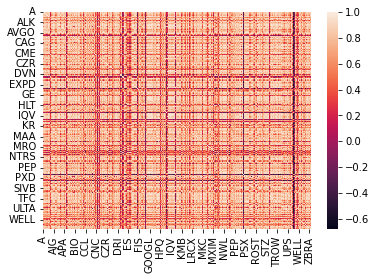

In [ ]:
import seaborn as sns
sns.heatmap(prices.corr())

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_prices = scaler.fit_transform(prices)

### Apply PCA (2.5 points)

* plot the explained variance ratio. Hint: `pca.explained_variance_ratio_`
* Represent the components which preserve maximum information and plot to visualize
* Compute the daily returns of the 500 company stocks. Hint: See the following [reference](https://towardsdatascience.com/stock-market-analytics-with-pca-d1c2318e3f0e).
* Plot the stocks with most negative and least negative PCA weights. Use reference as above. Discuss the least and most impacted industrial sectors in terms of stocks, during the pandemic period (Year 2020)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_prices)

PCA()

In [ ]:
table = [prices.columns.values[1:],pca.components_[0]]
pd.DataFrame(pca.components_.T,columns=['component '+str(i+1) for i in range(394)]
             ,index=prices.columns.values)

,component 1,component 2,component 3,component 4,component 5,component 6,component 7,component 8,component 9,component 10,component 11,component 12,component 13,component 14,component 15,component 16,component 17,component 18,component 19,component 20,component 21,component 22,component 23,component 24,component 25,component 26,component 27,component 28,component 29,component 30,component 31,component 32,component 33,component 34,component 35,component 36,component 37,component 38,component 39,component 40,...,component 355,component 356,component 357,component 358,component 359,component 360,component 361,component 362,component 363,component 364,component 365,component 366,component 367,component 368,component 369,component 370,component 371,component 372,component 373,component 374,component 375,component 376,component 377,component 378,component 379,component 380,component 381,component 382,component 383,component 384,component 385,component 386,component 387,component 388,component 389,component 390,component 391,component 392,component 393,component 394
A,-0.050449,-0.035209,0.018544,0.018475,0.008866,-0.024494,0.031576,-0.004663,-0.015303,0.003359,0.019853,0.014367,0.030533,-0.008689,-0.016461,0.021987,-0.003071,-0.013025,-0.017738,0.006089,0.033198,-0.031084,0.037584,0.018203,-0.019408,-0.007240,-0.019777,-0.032407,-0.026743,0.034125,-0.044959,0.010404,0.008009,-0.008965,-0.009447,-0.005987,0.008450,-0.001841,0.021946,0.000755,...,-0.025392,-0.000411,-0.027268,-0.104005,0.040094,-0.030742,0.065496,0.021508,-0.025112,0.040670,-0.095400,0.030336,-0.054358,-0.020663,0.021257,0.015743,-0.102692,-0.123616,0.008575,-0.001774,0.076767,-0.029270,-0.005100,-0.130972,-3.316324e-02,-0.037012,-0.010672,0.020752,0.073792,-0.066012,0.052451,-0.026979,0.025837,0.001790,-0.167573,-0.036742,0.021838,0.057380,-0.132990,0.125034
AAL,-0.034906,0.088895,0.013078,-0.018247,-0.001843,0.055669,-0.008322,-0.038317,-0.016699,0.026753,-0.006248,0.036533,0.015080,-0.096116,-0.036926,0.058970,-0.004127,0.052375,-0.036570,0.117996,-0.008083,0.064700,0.020509,-0.041027,0.016221,0.066949,-0.045657,0.114021,0.008068,0.006765,0.063757,-0.111227,-0.054587,0.036284,-0.052987,-0.056672,-0.023991,-0.070279,-0.087427,-0.044219,...,-0.013637,0.037688,-0.038277,0.102788,0.088508,-0.075437,-0.054181,-0.090845,-0.110191,-0.017147,0.011282,0.015348,0.018844,-0.012623,-0.061020,0.026808,0.010954,-0.017223,-0.072008,-0.067294,-0.004706,0.032419,-0.031407,0.011902,-1.582231e-02,0.013689,-0.085190,-0.052437,-0.013472,0.046627,0.007099,-0.004254,-0.022501,-0.072972,0.070822,-0.013722,-0.060343,-0.044800,0.058051,-0.023746
AAP,-0.050622,-0.018164,-0.010602,0.030253,0.010337,0.068455,0.010129,-0.003366,0.028991,-0.037704,0.024013,-0.003972,0.040817,0.116938,-0.078253,-0.015641,-0.012528,0.023479,-0.059372,-0.017394,0.009839,0.001909,-0.003129,0.059230,-0.019706,0.033356,-0.043165,0.040933,-0.027605,0.033711,0.026033,0.022844,0.032173,-0.058419,-0.008023,-0.015337,0.036021,-0.056130,-0.074296,0.003048,...,-0.015624,-0.004020,0.063916,0.044733,-0.028540,0.022103,0.039641,-0.021080,-0.041046,0.048768,0.015618,-0.029473,-0.015783,-0.006316,-0.004520,-0.039071,0.015850,0.019500,0.049180,-0.040730,0.018016,0.011508,-0.002611,0.015050,-4.708668e-02,0.016060,0.039682,-0.008014,0.015211,-0.084035,0.019804,0.000067,-0.073915,0.023897,0.067389,-0.040212,0.142944,0.019772,0.081815,0.157728
AAPL,-0.044606,-0.063214,0.009331,-0.032711,0.008643,0.014679,0.038718,-0.035812,-0.039552,0.035260,-0.033752,0.003396,0.040989,0.015740,-0.001091,0.010489,0.019380,0.042076,0.040514,0.034426,-0.011327,0.046918,-0.057875,0.034056,0.024418,-0.032507,0.041638,-0.008478,-0.010139,-0.009319,0.016576,-0.083228,-0.015095,-0.041767,-0.000099,0.022520,-0.013914,-0.028201,0.006587,0.036231,...,0.012542,0.031802,0.033339,-0.083376,0.012512,0.095882,-0.032513,-0.032598,0.087582,0.020787,-0.051679,0.010254,0.043470,-0.000709,-0.063989,0.058609,0.016239,-0.047908,-0.053765,0.042536,0.043653,-0.008269,0.01488

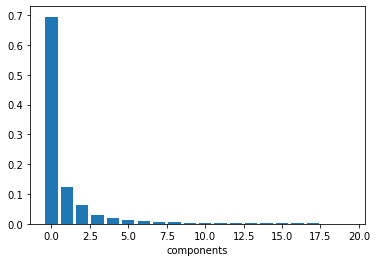

In [ ]:
plt.bar(range(len(pca.explained_variance_ratio_[:20])), pca.explained_variance_ratio_[:20])
plt.xlabel('components')
plt.show()

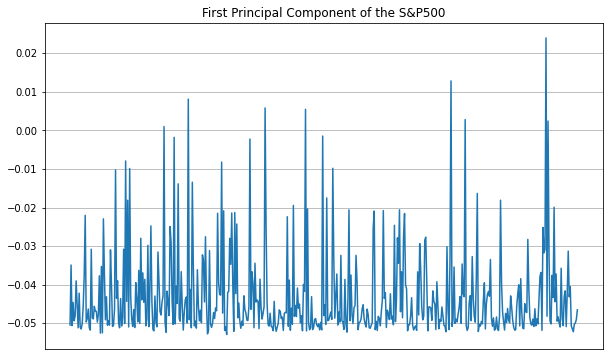

In [ ]:
pc1 = pd.Series(index=prices.columns, data=pca.components_[0])
pc1.plot(figsize=(10,6), xticks=[], grid=True, title='First Principal Component of the S&P500')

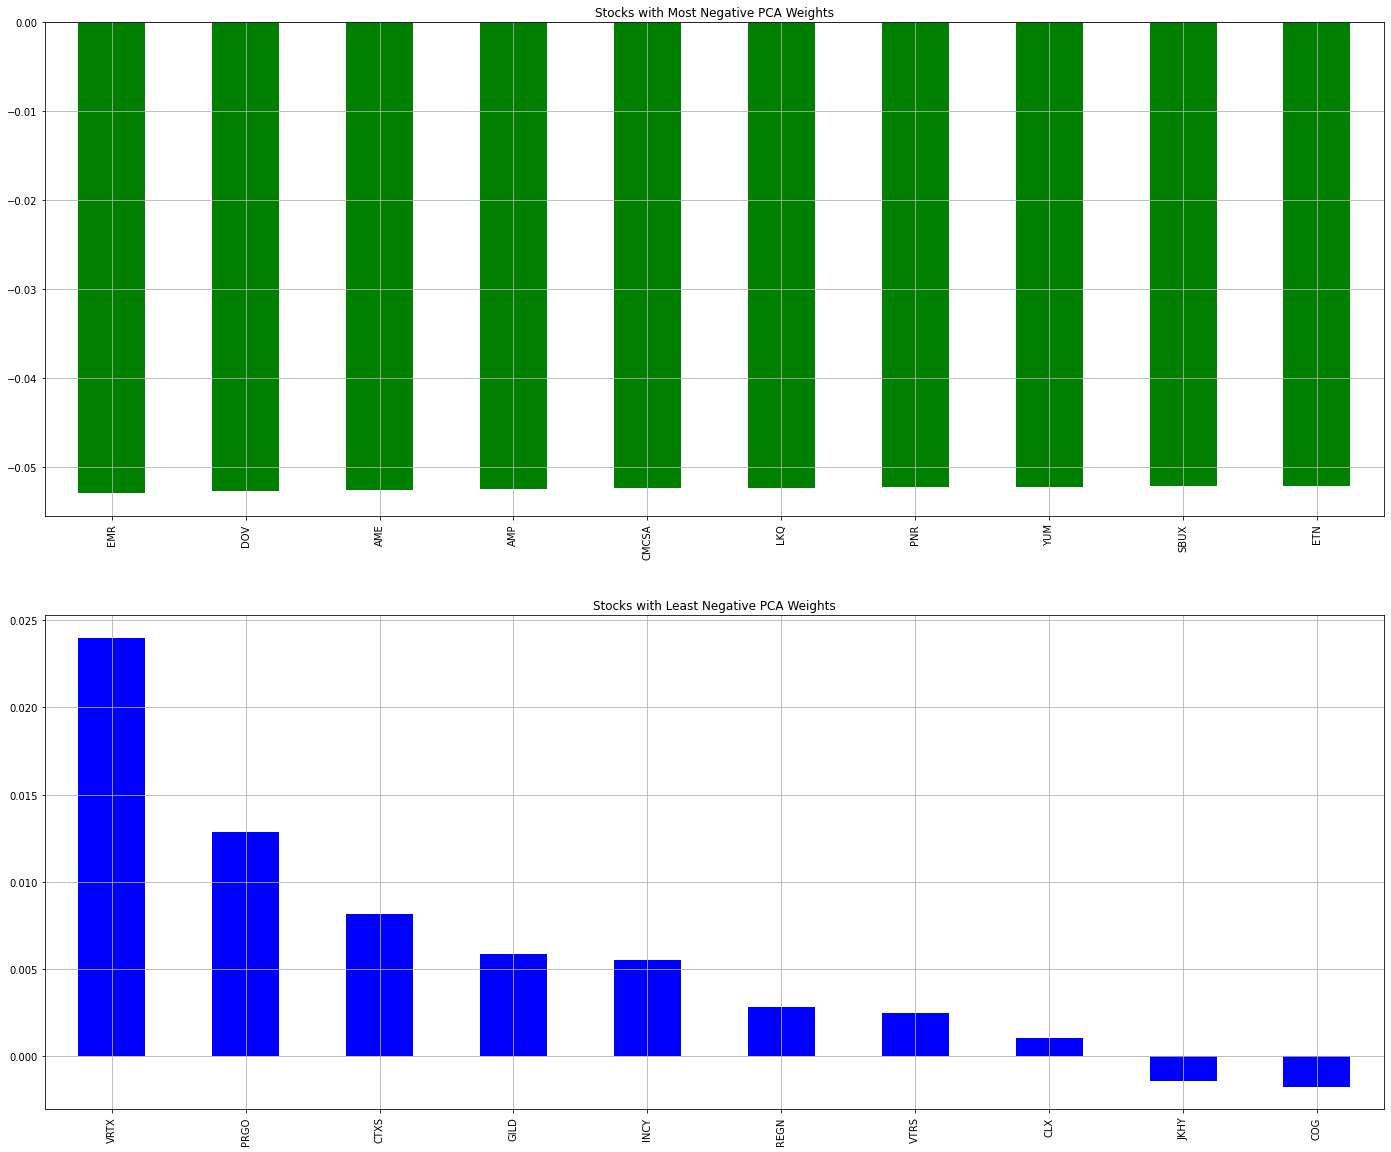

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(24,20))
pc1.nsmallest(10).plot.bar(ax=ax[0], color='green', grid=True, title='Stocks with Most Negative PCA Weights')
pc1.nlargest(10).plot.bar(ax=ax[1], color='blue', grid=True, title='Stocks with Least Negative PCA Weights')

#### Apply T-SNE and visualize with a graph (1 points)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


(394, 2)


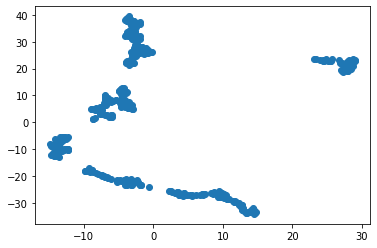

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, random_state = 0)
tsne_data = tsne.fit_transform(prices)
print(tsne_data.shape)
plt.scatter(tsne_data[:,0],tsne_data[:,1])
plt.show()

### Introduction to Anomaly Detection in Time Series with Keras</h2>


## Anomaly Detection (PART-B)

### Load and Preprocess the data

* Inspect the S&P 500 Index Data

In [ ]:
path = 'SPY.csv'

In [ ]:
df = pd.read_csv(path)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.983273,480500
1,1993-02-02,44.21875,44.37500,44.12500,44.34375,26.038315,201300
2,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.313566,529400
3,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.423655,531500
4,1993-02-05,44.96875,45.06250,44.71875,44.96875,26.405315,492100


In [ ]:
df.shape

(7134, 7)

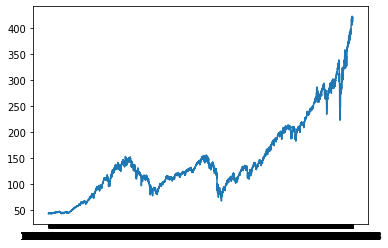

In [ ]:
plt.plot(df.Date, df.Close)
plt.show()

### Data Preprocessing (1 point)

In [ ]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(5707, 7) (1427, 7)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


### Create time series data ( 0.5 point)

Select the variable (column) from the data and create the series of data with a window size.

Refer [LSTM Autoencoder](https://medium.com/swlh/time-series-anomaly-detection-with-lstm-autoencoders-7bac1305e713)

In [ ]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values#.reshape(-1)
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [ ]:
time_steps = 30

X_train, y_train = create_dataset(train[['Close']], train.Close, time_steps)
X_test, y_test = create_dataset(test[['Close']], test.Close, time_steps)

print(X_train.shape)
print(y_train.shape)

(5677, 30, 1)
(5677,)


### Build an LSTM Autoencoder ( 1 points)

Autoencoder should take a sequence as input and outputs a sequence of the same shape.

Hint: [LSTM Autoencoder](https://medium.com/swlh/time-series-anomaly-detection-with-lstm-autoencoders-7bac1305e713)

In [ ]:
timesteps = X_train.shape[1]
num_features = X_train.shape[2]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed

model = Sequential([
    LSTM(128, input_shape=(timesteps, num_features)),
    Dropout(0.2),
    RepeatVector(timesteps),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    TimeDistributed(Dense(num_features))                 
])

model.compile(loss='mae', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVector  (None, 30, 128)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDistr  (None, 30, 1)            129       
 ibuted)                                                

In [ ]:
# # Create encoder submodel
# encoder = Sequential([Dense(32, activation='relu', input_shape=[30]),
#                       Dense(16, activation='relu'),
#                       Dense(8, activation='relu')
#                       ])

# # Create decoder submodel
# decoder = Sequential([Dense(16, activation='relu', input_shape=[8]),
#                       Dense(32, activation='relu'),
#                       Dense(30, activation='sigmoid')
#                       ])

# # Create autoencoder
# autoencoder = Sequential([encoder, decoder])
# autoencoder.compile(optimizer='adam', loss='mae')

### Train the Autoencoder (0.5 point)

* Compile and fit the model with required parameters

In [ ]:
model.compile(loss='mae', optimizer='adam')
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    shuffle=False)

Epoch 1/100
160/160 [==============================] - 11s 27ms/step - loss: 0.1709 - val_loss: 0.2609
Epoch 2/100
160/160 [==============================] - 3s 22ms/step - loss: 0.1179 - val_loss: 0.3841
Epoch 3/100
160/160 [==============================] - 3s 21ms/step - loss: 0.1052 - val_loss: 0.3727
Epoch 4/100
160/160 [==============================] - 3s 21ms/step - loss: 0.0956 - val_loss: 0.2971
Epoch 5/100
160/160 [==============================] - 3s 21ms/step - loss: 0.0967 - val_loss: 0.3794
Epoch 6/100
160/160 [==============================] - 3s 21ms/step - loss: 0.1090 - val_loss: 0.3509
Epoch 7/100
160/160 [==============================] - 3s 21ms/step - loss: 0.1055 - val_loss: 0.3134
Epoch 8/100
160/160 [==============================] - 3s 21ms/step - loss: 0.1123 - val_loss: 0.2632
Epoch 9/100
160/160 [==============================] - 3s 21ms/step - loss: 0.1302 - val_loss: 0.2673
Epoch 10/100
160/160 [==============================] - 3s 21ms/step - loss: 0.13

### Plot Metrics and Evaluate the Model (2 points)

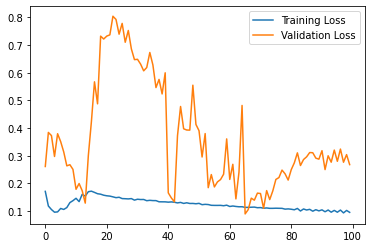

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend();

In [ ]:
X_train_pred = model.predict(X_train)
train_mae_loss = pd.DataFrame(np.mean(np.abs(X_train_pred - X_train), axis=1), columns=['Error'])

In [ ]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 0s 8ms/step - loss: 4.7576


4.757565498352051

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


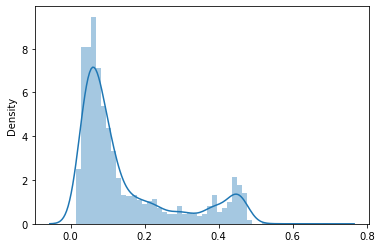

In [ ]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [ ]:
X_test_pred = model.predict(X_test)
test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


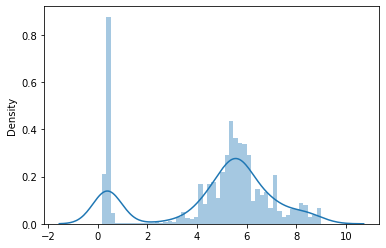

In [ ]:
sns.distplot(test_mae_loss, bins=50, kde=True);

### Detect Anomalies in the S&P 500 Index Data (1.5 points)

In [ ]:
THRESHOLD = 0.65

test_score_df = pd.DataFrame(test[time_steps:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['Close'] = test[time_steps:].Close

In [ ]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies.head()

,Date,Open,High,Low,Close,Adj Close,Volume,loss,threshold,anomaly
6016,2016-12-19,225.250000,226.020004,225.080002,2.750408,207.801712,90341100,0.768129,0.65,True
6017,2016-12-20,226.149994,226.570007,225.880005,2.772152,208.603333,89838800,0.948274,0.65,True
6018,2016-12-21,226.250000,226.449997,225.770004,2.756406,208.022858,67909000,1.126379,0.65,True
6019,2016-12-22,225.600006,225.740005,224.919998,2.746659,207.663513,56219100,1.320766,0.65,True
6020,2016-12-23,225.429993,225.720001,225.210007,2.754907,207.967590,36697800,1.498222,0.65,True


### Data Preparation

In [ ]:
!pip -qq install yfinance

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

In [ ]:
spy_ohlc_df = yf.download('SPY', start='1993-02-01', end='2021-06-01')

In [ ]:
spy_ohlc_df.head()

In [ ]:
spy_ohlc_df.tail()

In [ ]:
spy_ohlc_df.shape

In [ ]:
spy_ohlc_df.reset_index(inplace=True)

In [ ]:
spy_ohlc_df.to_csv("SPY.csv",index=False)